In [1]:
from IPython.display import Image

import pandas as pd
import numpy as np

In [2]:
SEED = 42

# Работа с текстовыми данными 🤓

Алгоритмы, вообще говоря, напрямую не умеет работать с текстом/словами, поэтому необходимо уметь преобразовывать его/их в векторное представление из чисел, при чем желательно, чтобы этот вектор был не слишком большой размерности.

## Примеры задач

    Предсказание по тексту его рейтинга
    Определение эмоционального окраса текста (Sentiment Analysis)
    Определение темы текста (тематическое моделирование)
    Кластеризация новостей по сюжетам
    Построение аннотаций текста
    и многое-многое другое

## Преобразование категориальных признаков

По сути, самый тривиальный пример - наличие категориальных признаков, которые могут быть как числовыми, так и буквенными/словесными, а, значит, надо такие фичи как-то кодировать.

Остановимся на наиболее используемых методиках кодирования категориальных признаков: **label encoding**, **one hot encoding (dummy encoding)**, **target encoding** 

In [3]:
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder 

**Label encoding** заключается в том, что каждая уникальная категория отождествляется с номером от 1 до N, где N - число уникальных категорий, можно сказать, что расставляются своего рода ранги.

Стоит отметить, что помимо label encoding есть ordinal encoding, единственное отличие между которыми состоит в том, что label encoding не учитывает истинный порядок объектов.
<br>
*Например*, рассмотрим образование: начальное, среднее, высшее, виден порядок и под ordinal encoding зачастую понимается кодировка именно в виде *начальное $\rightarrow$ 1, среднее $\rightarrow$ 2, высшее $\rightarrow$ 3*

**Что хорошего?** Теперь любой алгортм сможет принять такой закодированный столбец
<br>
**Что плохого?** Может сложиться впечатление, что одна категория больше, например, другой, что, вообще говоря неверно, а также что можно складывать категории, то есть неявным образом введена алгебра, например в случае 
метрических алгоритмов, очевидно, что это доставляет проблемы ввиду их особенностей работы.
<br>
**Примеры, где реализовано:** pandas.factorize, sklearn.preprocessing.LabelEncoder, category_encoders.OrdinalEncoder

**One Hot Encoding**

Создает N новых столбцов 1..N (по числу уникальных категорий), при чем i-я строка принимает в j-м столбце 1 тогда и только тогда, когда он соответствует заданному признаку, в остальных столбцах i-й строки стоят 0

**Что хорошего?** Вновь преобразовали в числа, также линейные алгоритмы уже могут улавливать линейную зависимость, например
<br>
**Что плохого?** В случае большого числа уникальных категорий мы добавляем много новых признаков, что замедлит работу алгоритма, а слишком большая разреженность в данных плоха, например, для алгоритмов, основаных на деревьях решений
<br>
**Примеры, где реализовано:** pandas.get_dummies, sklearn.preprocessing.OneHotEncoder, category_encoders.OneHotEncoder

**Замечание**: есть еще, так называемое, dummy кодирование, которое представляет то же самое one hot, но главным отличием является то, что один произвольный признак выбрасывается, так как при исходном кодировании у нас получаются линейно зависимые признаки. Как известно, для линейных моделей мультиколлениарность это плохо, но в эру регуляризаторов даже на это можно не обращать внимание, они сделают всю работу за нас :)

**Target encoding**

Один из популярнейших способов кодирования особенно в случае использования GBDT алгоритмов. Учитывает значения целевого события при преобразовании категориального признака.

Процесс преобразования (тривиальный вариант, так делать никогда не стоит):

    Группировка по фиче
    Подсчет среднего арифмитического целевого события в группах

**Что хорошего?** Все еще можем передавать в любые алгоритмы, дает, как правило, лучше результаты, чем другие способы кодирования при применении алгоритмов GBDT
<br>
**Что плохого?** Используем таргет, следовательно, переобучаемся под него
<br>
**Примеры, где реализовано:** category_encoders.TargetEncoder

Обычно используется при решении задач классификации, но можно и для регрессии.

Есть несколько способов снизить переобучения (добавить регуляризацию):
    
    1. KFold scheme
    2. Leave-one-out scheme
    3. Smoothing (по сути, все,что штрафует кодирование редких категорий, некий регуляризатор "доверия"               кодировщику)
    4. Expanding mean scheme
    5. Adding random noise
    
 Зачастую используют 1 или 4 способы, к которым можно также добавить 3. 4, например, реализован в catboost.
 
Закрепим на игрушечном примере:

In [4]:
df = pd.DataFrame({'f':['w', 'b', 'a', 'c', 'c', 'c', 'b', 'e']
                   , 'y': [0, 0, 1, 1, 1, 0, 1, 1]})

print('Count of unique categorical values:', df['f'].unique().shape[0])

f_ord = OrdinalEncoder().fit_transform(df['f'])
f_ord.columns = ['f_ordenc']

f_ohe = OneHotEncoder().fit_transform(df['f'])
f_ohe.columns = [f'f_ohe_{i}' for i in range(f_ohe.shape[1])]

f_naive_meanenc = pd.DataFrame(df.groupby(['f'])['y'].transform('mean').to_numpy(), columns=['f_naive_meanenc'])
              
f_meanenc = TargetEncoder(smoothing=5).fit_transform(df['f'], df['y'])
f_meanenc.columns = ['f_meanenc']

df = pd.concat([df, f_ord, f_ohe, f_naive_meanenc, f_meanenc], axis=1)

df

Count of unique categorical values: 5


,f,y,f_ordenc,f_ohe_0,f_ohe_1,f_ohe_2,f_ohe_3,f_ohe_4,f_naive_meanenc,f_meanenc
0,w,0,1,1,0,0,0,0,0.000000,0.625000
1,b,0,2,0,1,0,0,0,0.500000,0.556271
2,a,1,3,0,0,1,0,0,1.000000,0.625000
3,c,1,4,0,0,0,1,0,0.666667,0.649945
4,c,1,4,0,0,0,1,0,0.666667,0.649945
5,c,0,4,0,0,0,1,0,0.666667,0.649945
6,b,1,2,0,1,0,0,0,0.500000,0.556271
7,e,1,5,0,0,0,0,1,1.000000,0.625000


## Текстовые данные

Прежде чем начать кодировку текстовых данных полезно выполнить ряд процедур таких, как приведение в один регистр, удаление стоп-слов, произвести нормализацию, удалить пунктуацию и т.д.

**Вопсрос**: Какие вообще есть сложности и особенность при работе с текстовыми данными?

    Омонимы, синонимы, опечатки и ошибки, неологизмы, пунктуация, порядок слов, контекст, устойчивые словосочетания и др.

Рассмотрим основные этапы, которые часто делают при работе с текстами:
* Приведение в один регистр

* Удаление (обработка) пунктуации, а так же чисел (можно перевести их в текстовое описание) и прочих символов. Например, можно заменить на пробелы, но стоит делать это осторожно, так как могут быть общепринятые сокращения, например, "к.т.н", "ООО", смайлы помогают определить эмоциональность текста и т.п.
   
* Токенизация - разбиение на отдельные "слова"
   
* Нормализация - приведение слова к его начальной форме:
        
   * **Стемминг** - "стрижка" слова, то есть по некоторому правилу убираются несколько последних букв. Быстро, но далеко не всегда хорошо, возьмем в качестве примера глагол "быть" и его формы: был, есть, будет. Как ни "стриги" каждое из слов, они все будут отличаться друг от друга и никакой начальной формы не виднеется. Весьма неплохо подходит для английского языка.
    
   * **Лемматизация** - приведение слова в начальной форме путем использования некоторого словаря, в котором она хранится, если же такой формы не нашлось, то по определенному алгоритму выводится способ изменения слова. Так, например, все слова из примера выше могут быть приведены к одной форме "быть". Лемматизация лучше подходит для русского языка. Важно понимать, что и время работы ее дольше в сравнении со стеммингом.
    
* Удаление стоп-слов - общеупотребимых слов (союзы, предлоги, междометия и т.п.), то есть таких слов, которые часто встречаются вне зависимости от текста.
   
* Удаление редких слов, то есть таких, которые, например, встречаются всего пару раз во всей коллекции. Маловероятно, что таких слова смогут улучшить алгоритм
   
* Извлечение коллакация (устойчивых вырожений).
  * Подход N-грамм: взять K самых частых N-gramm
  * Подход PMI (Pointwise mutual information). $PMI(x, y) = \log \frac{p(x, y)}{p(x)p(y)}$ Чем больше PMI, тем больше вероятность что два события $x$ и $y$ происходят вместе. Далее надо вручную подобрать порог $thr$, выше которого N-gramm будут объявлены коллакациями
  * Комбинирование двух предыдущих подходов: берем топ по $PMI > thr$, затем топ-K по частотам N-gramm либо выбрать том-K по частотам и топ-M по $PMI$ и пересечь полученные N-gramm
   
* **k-skip-n-grams** - набор из токенов длины n, причем расстояние между соседними должно составлять не более k токенов. Польза n-грамм состоит, например, в том: "любить" и "не любить" - два глагола противоположного смысла, подход 2-грамм учтет данный окрас, в то время как обычная токенизация разобьет "не любить" на 2 отдельных токена, а отдельная частица "не" врядли сможет привести к хорошему качеству. Так же k-skip-n-grams могут быть буквенными, то есть оперировать именно последовательностью символов
   
   Пример, возьмем предложение: _"Хочу кайфовать и короткие лекции"_. Выбросим стоп слово "и", получим:
    * Униграммы (1-gramms): хочу, кайфовать, короткие, лекции
    * Биграммы (2-gramms): хочу кайфовать, кайфовать короткие, короткие лекции
    * 1-skip-2-gramm: биграммы + хочу короткие, кайфовать лекции 
   
* Преобразование полученного результата в вектор чисел (о подходах пойдет речь ниже)
   
**Важно** понимать, что, по сути, обработка текста это в какой-то степени процесс творческий и зависит от конкретной задачи, что-то можно делать, что-то нет. Работая с русским текстом, можно, например "ё" заменить на "е", проверить, что буква "о" взята из русского алфавита, а не английского, глаголоы с "не" сливать при помощи нижнего подчеркивания: "не пью" -> "не_пью" и т.д.

В качестве примера рассмотрим датасет 20newsgroups, где надо классифицировать тексты по 20 тематикам

In [5]:
#загрузка текстового датасета
from sklearn.datasets import fetch_20newsgroups

#from pymystem3 import Mystem #для использования лемматизации
import spacy #для использования лемматизации
from nltk.corpus import stopwords #для выбрасывания стоп слов

import re

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Barnett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#simple function of text preprocessing
def preprocess_text(series_column, stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    ''' Simple text preprocessing
        
    Parameters:
        series_column - pandas.series
        stop_words - list of stop words
        allowed_postags - what types of words must be kept after lemmatization
        
    Return:
        preprocessed series
    '''
    series_column = series_column.str.lower()
    #series_column = series_column.replace(r'[^a-z]', ' ', regex = True)
    
    for i, text in series_column.iteritems():
        
        #drop emails
        text = re.sub('\S*@\S*\s?', '', text)
        # Remove distracting single quotes
        text = re.sub("\'", "", text)
        #keep only letters
        text = re.sub('[^a-z]', ' ', text)
        
        #drop whitespaces
        text = ' '.join(text.split())
        
        #normalization and drop stop words and too short ones
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if token.pos_ in allowed_postags
                                                   and token.lemma_ not in stop_words
                                                   and len(token.lemma_) > 2]
        
        #old approach but faster than spacy
        #tokens = mystem.lemmatize(text)
        #tokens = [token for token in tokens if token not in [' ', '\n'] 
        #                                      and token not in stop_words
        #                                      and len(token) > 2]
        
        text = ' '.join(tokens)
        series_column[i] = text
    
    return series_column

In [8]:
#mystem = Mystem() #must be defined beforehand to speed up
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

Посмотрим, что же это за стоп-слова такие:

In [9]:
for i, word in enumerate(stop_words, start=1):
    if not i % 15:
        break
    print(word, end=', ')

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, 

In [10]:
df = pd.DataFrame({'text': fetch_20newsgroups(subset='train')['data']
                   , 'target': fetch_20newsgroups(subset='train')['target']
                  })

d = dict(zip(range(20), fetch_20newsgroups(subset='train')['target_names']))
df['target_names'] = list(map(lambda x: d[x], df['target']))

print(df.shape)
df.head(3)

(11314, 3)


,text,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware


In [11]:
%%time
df['text'] = preprocess_text(df['text'], stop_words)

CPU times: user 2min 33s, sys: 6.06 s, total: 2min 39s
Wall time: 2min 40s


In [12]:
df.head(3)

,text,target,target_names
0,thing subject car nntp post host line wonder c...,7,rec.autos
1,poll final summary final call clock report key...,4,comp.sys.mac.hardware
2,subject question computer network distribution...,4,comp.sys.mac.hardware


## Кодирование текста

In [13]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

### Bag of words (BoW)

Пожалуй, самая простая модель представления текстовых данных. Базируется на количестве вхождения слова в документе.

Пусть есть N уникальных слов коллекции $w_1,..., w_N$. Каждый документ (текст) кодируется вектором длины N, причем i-й признак равен количеству (либо доле) вхождений слова $w_i$ в документе, также может рассматриваться не количество вхождений, а доля, то есть производится нормировка.

Если слово встречается часто, то оно не важно (ествественно, стоп-слова не учитываются).

Как можно заметить, для BoW не важен порядок слов в документе. Одно из преимуществ заключается в том, что значение  каждого числа в векторе интерпретируемо, но в то же время есть и недостаток, заключающийся, что для большого корпуса слов будут получатся огромные векторы

**Рассмотрим на примере:** 😏

    "Вася сдал все экзамены и пошел в магазин за пивом и виски. Виски Вася любит без колы"
    "А его сосед Ваня экзамен не сдал, но виски любит тоже"

Предположим, что мы предобработали текста примерно по алгоритму выше, не используя k-skip-n-gramm (*плохо ли это?*) и получили:
    
    "вася, сдать, экзмен,  идти, магазин, пиво, виски. виски, вася, любить, кола"
    "сосед, ваня, экзамен, не_сдавать, виски, любить"

In [14]:
sent1 = 'вася сдать экзамен идти магазин пиво виски виски вася любить кола'
sent2 = 'сосед ваня экзамен не_сдавать виски любить'
corpus = [sent1, sent2]

for i, x in enumerate(corpus):
    corpus[i] = ' '.join(x.split())
    
corpus

['вася сдать экзамен идти магазин пиво виски виски вася любить кола',
 'сосед ваня экзамен не_сдавать виски любить']

**Вопрос 1**: сколько уникальных слов?

**Вопрос 2**: Выберите любые два слова из разных предложения и скажите, как они закодируются (например, "виски" из 1-го и "любить" из 2-го)

Вернемся к исходному датасету новостных групп

Посчитаем количество уникальных слов во всей коллекции

In [15]:
s = set()
for row in df.iterrows():
    s |= set(row[1]['text'].split())
print(f"Cnt of unique words: {len(s)}")

Cnt of unique words: 40943


In [16]:
vectorizer = CountVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 1))
matrix = vectorizer.fit_transform(df['text'])
print(matrix.shape)
matrix.toarray()[:5, :20]

(11314, 243)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]])

Как видно получили матрицу "счетчик слов", которая является разреженной

### TF-IDF

(term frequency-inverse document frequency)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

Несколько более сложный подход к формированию вектора признаков.

Также чем чаще встречается слово в документе, тем оно важнее, но есть и вторая сторона: если слово встречается редко в других документах, то, скорей всего, оно также важно для текущего текста, и по этому слову данный документ можно отлечить от остальных.

**TF**  — это частотность термина, которая измеряет, насколько часто термин встречается в документе.
<br>
**TF слова $word$** = (Количество раз, когда $word$ встретился в документе $d$ $/$ количество всех слов в документе). Обозначим за $n_{dw}$
<br>
В длинных документах слово может встретиться чаще, чем в коротких, поэтому пользуются не абсолютными, а относительными числами.

**IDF** — это обратная частотность документов. Она измеряет непосредственно важность термина.
<br>
**IDF слова $word$** = логарифм(Общее количество документов / Количество документов, в которых встречается слово $word$ хотя бы один раз). Обозначим за $log \frac{M}{n_{w}}$
<br>
Основание логарифма, по факту, особой роли не играет, в основном берут натуральный.

**TF-IDF слова $word$ = (TF слова $word$) * (IDF слова $word$)**, или
<br>
TF-IDF($d$, $w$) = $n_{dw} * log \frac{M}{n_{w}}$

**Вернемся к нашему примеру:**

In [18]:
corpus

['вася сдать экзамен идти магазин пиво виски виски вася любить кола',
 'сосед ваня экзамен не_сдавать виски любить']

**Вопрос**: Выберите любые два слова из разных предложения и скажите как они закодируются (например, "виски" из 1-го и "ваня" из 2-го)

А теперь на исходном новостном датасете

In [19]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 1))
matrix = vectorizer.fit_transform(df['text'])
print(matrix.shape)
matrix.toarray()[:5, :10]

(11314, 243)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.46920784, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.11589139, 0.10595468, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.24505395,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.24827362]])

Матрица также получается разреженной.
<br>
Зачастую подход tf-idf показывает лучше качество, чем BoW, но опять-таки зависит от корпуса документов :)

### Word2Vec

**Вопрос**: Как можно мерить расстояние между текстами/словами?

Одним из популярных способов является косинусная мера: $$\cos(a, b) = \frac{<a, b>}{||a||| |b||}$$

Как вы могли замететь ранее, что размерности векторов, полученным применением BoW и TF-IDF могут получаться довольно большими, а так же схожие слова типа "быть", "есть", "буду" хоть и имеют для человека схожий смысл, но компьютер пока что не способен их различать.

Рассмотрим алгоритм, решающий данные проблемы

Word2vec - метод для создания векторного представления слов, основанный на нейросети прямого распространения. Эмбединги могут быть получены на основе одного из двух алгоритмов: Continuous Bag of Words (CBOW) и Skip-gram, - которые "говорят" как именно нейросеть должна учиться на данных и запоминать слова.

**CBOW** 

    Предсказание слова при заданном контексте
    Так как модель на основе мешка слов, то порядок следования слов не учитывается
    Быстрее, чем Skip-gram
    Рекомендуемый размер окна - около 5, но опять-таки зависит от корпуса
    Обычно предпочтительнее для огромных коллекций (сотни миллионов слов), так как учится быстрее и лучше справляется с частотными словами
    
    
**Skip-gram**

    Предсказание контекста при заданном слове
    Медленнее, чем CBOW
    Рекомендуемый размер окна - около 10, но опять-таки зависит от корпуса
    Обычно предпочтительнее для сравнительно небольших коллекций (не более ста миллионов слов), так как работает небыстро и лучше учитывает редкие слова
    
    
Рассмотрим Skip-gram чуть подробнее:

**Задача:** представить каждое слово $w$ как вектор $\vec{w}$ размерности $d$

Чтобы найти вектор $\vec{w}$ надо работать с вероятностями $p(w_i|w_j) = \frac{\exp(<\vec{w_i}, \vec{w_j}>)}{\sum_w \exp(<\vec{w_i}, \vec{w_j}>)}$ - вероятность встретить слово $\vec{w_i}$ в контексте $\vec{w_j}$

Векторы слов настраиваются так, чтобы вероятности встретить слова из одного контекста были высокими. 
$$\prod_{i=1}^{n}\prod_{j=-k}^{k}p(w_{j+i}|w_{i}) \rightarrow \max$$ -
максимизируем функционал, например, методом градиентного спуска, вероятности встретить слово вместе со $k$ словами до и после, $k$ - параметр, именуемый размером окна.

С произведением работать тяжело, поэтому перейдем к логарифмам
$$-\sum_{i=1}^{n}\sum_{j=-k}^{k}\log p(w_{j+i}|w_{i}) \rightarrow \min$$

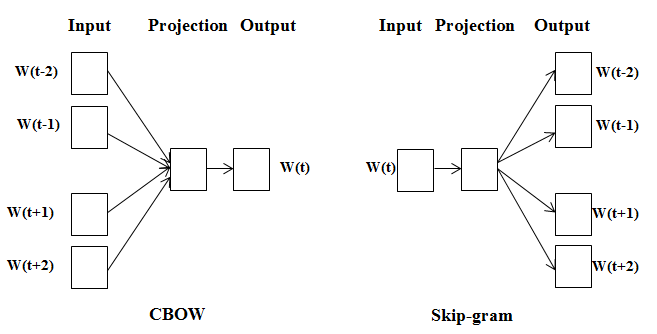

In [20]:
Image(filename='../pictures/cbow_skipgram.png')

Как устроен 

**Свойства векторных представлений, используя w2v**

$king−man+woman \approx queen$,
<br>
$Moscow − Russia + England \approx London$

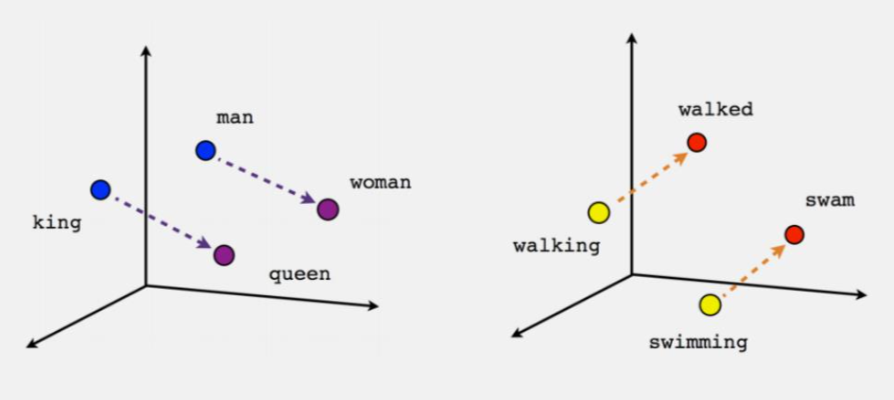

In [21]:
Image(filename='../pictures/w2v_feature.png')

Итак, w2v хорош тем что: 

    Размерность итогового пространства адекватного размера (например, 300)
    Похожие слова имеют близкие векторы (например, по косинусной мере)
    Арифметические операции над векторами имеют смысл
    
Закодировав слова, можно, например, усреднить вектора слов в тексте и получить признак для текста в виде вектора чисел. 
<br>
Можно воспользоваться еще одним подходом: Doc2Vec

Есть и другие методы построения эмбедингов для слов: fastText, GloVe и т.д. 

Также, если исходный корпус не очень большой, то может иметь смысл использование предобученного word2vec или другого инструмента

In [22]:
from gensim.models import Word2Vec

In [23]:
#на вход требуется список списков
matrix_text = [sent.split() for sent in df['text']]

In [24]:
%%time
#CBOW is used when sg=0
w2v = Word2Vec(matrix_text, size=300, sg=0, iter=10, window=5)

CPU times: user 1min 1s, sys: 419 ms, total: 1min 1s
Wall time: 24.4 s


Как получить вектора слов?

Например, так

In [25]:
d = dict(zip(w2v.wv.vocab.keys(), [w2v.wv[word] for word in w2v.wv.vocab.keys()]))
pd.DataFrame.from_dict(d, orient='index').head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
thing,1.383229,0.029228,-1.494042,0.403905,-0.146251,0.392695,-0.847580,0.047040,-0.117422,0.804901,...,0.112771,1.334434,1.274801,-0.191475,0.142028,-0.809399,1.566785,-0.172006,-0.695880,0.308146
subject,-1.206712,-0.262541,-0.073670,-0.394145,0.121958,-0.541965,-0.424896,-0.599519,0.041558,-0.361584,...,0.954852,-0.092269,-0.533555,1.065122,-1.000434,-1.579842,0.299859,0.111649,0.943495,0.556749
car,-0.752951,-0.713462,-0.419853,0.308682,-0.680266,1.255685,-0.250291,-0.750372,-0.088622,-0.649657,...,0.871287,0.229387,-0.477585,-0.842211,0.737183,0.606396,0.780946,-1.147878,0.635834,0.552103
nntp,-1.804067,1.950224,-0.824052,-1.569021,1.579135,-1.494486,-1.159817,0.138067,-0.917735,-0.333807,...,-0.250949,0.686281,0.308609,1.084863,-0.920954,-1.352899,-1.420113,-0.672901,-0.381651,-0.623799
post,-1.110893,-0.805993,-1.015929,1.095909,-0.405468,-1.181853,0.101109,-0.352925,1.026453,0.087027,...,-0.481357,-1.557060,-0.186989,0.180326,-1.276174,0.003346,0.701584,-0.703904,0.916720,-0.105256


Или так

In [26]:
w2v.wv.vectors

array([[-1.6201559e+00,  4.5880258e-01, -1.2840830e+00, ...,
         9.4121742e-01,  6.0483098e-01, -1.8358050e-01],
       [-1.8167717e+00, -3.5201043e-01, -9.5907128e-01, ...,
         1.7828462e-01,  1.4766086e+00,  1.0215431e-02],
       [-1.3380487e-01,  2.0184588e-01, -1.1768534e+00, ...,
         2.0420153e-01,  5.6502122e-01, -5.4250312e-01],
       ...,
       [-1.1137223e-01,  1.1682449e-01,  6.7980647e-02, ...,
        -1.2154545e-01, -8.5138313e-02, -1.5621224e-02],
       [ 9.4863037e-03,  8.0924049e-02,  1.6894259e-02, ...,
        -7.4402608e-02, -7.4615620e-02, -4.8183993e-02],
       [-2.6432440e-02,  1.0458692e-01, -1.3573755e-03, ...,
        -3.6483284e-02, -1.8780682e-02,  4.1748077e-02]], dtype=float32)

Посмотрим на некоторые методы:

In [27]:
w2v.wv.most_similar(['car'])

[('dealership', 0.7231693863868713),
 ('mustang', 0.6914525032043457),
 ('luxury', 0.6905907988548279),
 ('bike', 0.6852374076843262),
 ('tire', 0.670231819152832),
 ('convertible', 0.6485171318054199),
 ('mercede', 0.6464513540267944),
 ('volvo', 0.6453106999397278),
 ('coupe', 0.6335327625274658),
 ('sedan', 0.6334097981452942)]

In [28]:
w2v.wv.most_similar(['male'])

[('female', 0.8802722692489624),
 ('homosexual', 0.765432596206665),
 ('intercourse', 0.7530974745750427),
 ('promiscuous', 0.7441995143890381),
 ('gay', 0.7341604828834534),
 ('tribe', 0.7180024981498718),
 ('discrimination', 0.7036697864532471),
 ('heterosexual', 0.6992640495300293),
 ('lesbian', 0.6955234408378601),
 ('epidemic', 0.6853618621826172)]

In [29]:
w2v.wv.similarity('woman','man')

0.71727264

In [30]:
w2v.wv.doesnt_match(['man', 'women', 'car', 'person', 'people', 'male'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'car'

## Тематическоe моделирование

**Цели тематического моделирования:**

   * Классификация и категоризация документов. Пусть у нас есть большая коллекция текстовых документов и мы хотим разложить их по темам, тематическое моделирование обладает особенностью, что позволяет отнсти документ сразу к нескольким темам 
   * Автоматическое аннотирование документов. Можно выделить в документе наиболее важные фразы и составить на их основе аннотацию.
   * Тематическая сегментация документов - разбиение большого документа на фрагменты и определение темы каждого из них
    
    Таким образом, например, можно обработать тысячи статей википедии и при помощи тематического моделирования выделить темы, позволяющие понимать о чем та или иная статья
    
**Пример использования**:

Тематизация википедии 216175 русско-английских пар статей, собрано 400 тем.
<br>
Независимый эксперт оценил 396 тем как хорошо интерпретируемые

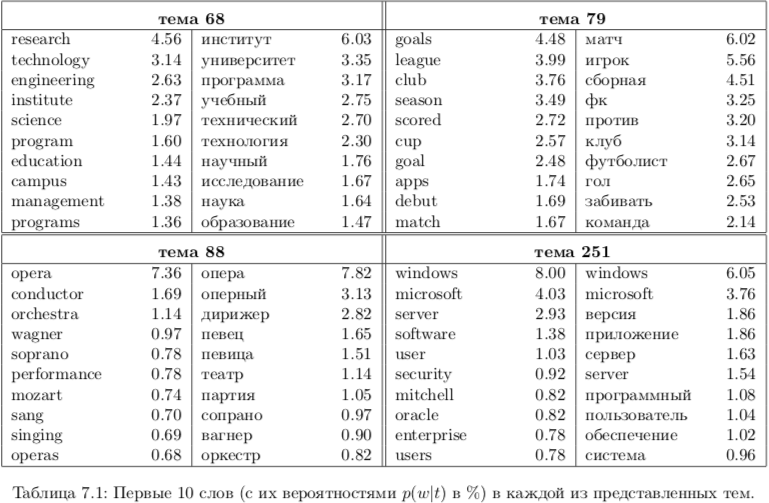

In [31]:
Image(filename='../pictures/topic_modeling_example.png')

**Тематическая модель** — модель коллекции текстовых документов, которая определяет, к каким темам относится каждый документ коллекции. 

**Тема** — набор терминов, то есть слов или словосочетаний, которые совместно часто встречаются в документах

Тема является интерпретируемой, если по топовым словам (см. выше, например, топ-10 слов), эксперты способны определить о чем данная тема, дать ей название и оценить интерпретируемость по некоторой балльной шкале

Формализуем:

**тема** - условное распределение на множетве терминов,
<br>
$p(w|t)$ - вероятность термина $w$ в теме $t$, или из каких терминов состоит каждая тема

**тематический профиль документа (тематика документа)** - из каких тем состоит документ, или условное распределение
<br>
$p(t|d)$ - вероятность темы $t$ в документе $d$, появляется ввиду того, что документ может относится к нескольким темам

Вероятность здесь эквивалентна частоте.

Тематическая модель должна автоматически выявлять латентные (скрытые) темы по наблюдаемым частотам терминов в документе $p(w|d)$



**Пусть** (базовые предположения простых тематических моделей)

   * Допускается гипотеза условной независимости: $p(w|d, t) = p(w|t)$ - вероятность слова в документе определяется только темой, а не документом
   * Порядок документов в коллекции не важен
   * Порядоктерминов в документе не важен (гипотеза "мешка слов")
   * Употребление каждого слова в каждом документе связано с некоторой темой
   
*Бывает выделяют еще дополнительные предположения:*

   * Каждый документ $d$ и каждый термин $w$ связан с небольшим числом тем (гипотеза разреженности)
   * Тема $t$ состоит из небольшого числа терминов $w$, отличающих эту тему существенно от остальных
   
   <br>
   $W$ - словарь терминов
   <br>
   $T$ - конечное множество тем
   <br>
   $D$ - конечное множество документов

Задается тематическая вероятностная модель на множестве документов $D$, описывающая вероятность появления слова $w$ в документе $d$ с темами $t$

$$p(w|d) = \sum_{t \in T}p(w|t)p(t|d)$$

------------------------------------------------------------------------------------------------------------------

**Прямая задача**: Порождение коллекции документов по $p(w|t)$ и $p(t|d)$

**Дано**: 

   * распределение $p(w|t)$ для каждой темы $t \in T$
   * распределение $p(t|d)$ для каждого документа $d \in D$
   
**Делаем**:

   * для всех $d \in D$:
       задаем длину $n_d$ документа $d$
       * для всех $i = 1..n_d$:
           * сгенерировать тему (выбрать случайную) $t_i$ из $p(t|d)$
           * сгенерировать термин (выбрать случайный) $w_i$ из $p(w|t_i)$
           * добавить в выборку пару $(d, w_i)$, при этом забывая тему $t$
           
**Получаем**:

    Коллекцию текстовых документов - выборка пар $(d_i, w_i)$, $i=1...n$
    
------------------------------------------------------------------------------------------------------------------

**Обратная задача**: восстановление $p(w|t)p(t|d)$ по имеющейся коллекции текстовых документов


**Дано:**
<br>
$\hat{p}(w|d) = \frac{n_{dw}}{n_d}, n_{dw} - $ количество вхождений слова $w$ в документ $d$, $n_d$ - длина документа

**Найти:** параметры тематической модели $\phi_{wt}=p(w|t), \theta_{td}=p(t|d)$, то есть по наблюдаемой коллекции необходимо понять, какими распределениями $\phi_{wt}, \theta_{td}$ она могла бы быть получена

**Получили:** задачу стохастического матричного разложения
<br>
Матрицы называются стохастическими, если каждый их столбец преставляет собой дискретное распределение верояностей, а ,следовательно, сумма значений по каждому столбцу равна 1 (условие нормировки) и каждое значение является неотрицательным (условие неотрицательности)

$\Phi = (\phi_{wt})$ - матрица распределений терминов в темах $\Theta = (\theta_{td})$ - матрица распределений тем в документах.

Но задача некорректно поставлена, потому что ее решение, вообще говоря, не единственно: $\Phi \Theta = (\Phi \Sigma)(\Sigma^{-1} \Theta) = \Phi^{'} \Theta^{'}$

**Решение:**

Пользуемся принципом максимума правдоподобия с ограничениями, полученными на основе того, что матрицы стохастические.

$$\sum_{d \in D}\sum_{w \in d}n_{dw} \ln \sum_{t \in T} \phi_{wt} \theta_{td} \rightarrow \max_{\Phi \Theta}$$
при условиях
$$\sum_{w \in W}\phi_{wt} = 1, \sum_{t \in T}\phi_{td} = 1, \phi_{wt} \geq 0, \theta_{td} \geq 0$$

Некорректность исходной задачи позволяет вводить дополнительный ограничения на матрицы $\Phi$ и $\Theta$, которые принято называть регуляризаторами. Таким образом, чтобы выбрать наиболее подходящее решение, вводится регуляризатор $R(\Phi, \Theta)$ - некоторый функционал, построенный из определенных соображений под задачу.
<br>
В итоге максимизируется не просто логарифм правдоподобия, а $$\sum_{d \in D}\sum_{w \in d}n_{dw} \ln \sum_{t \in T} \phi_{wt} \theta_{td} + R(\Phi, \Theta) \rightarrow \max_{\Phi \Theta}$$
(с теми же ограничениями)

Матрицы $\Phi$ и $\Theta$ могут быть эффективно вычислены с помощью итеративного EM-алгоритма.

Два самых известных частных случая данной системы уравнения: PLSA, LDA

**PLSA (вероятностный латентный семантический анализ)**: $$R(\Phi, \Theta) = 0$$

Основные недостатки PLSA:

1. Число параметров растёт линейно по числу документов в коллекции, что может приводить к переобучению модели.
<br>
2. При добавлении нового документа $d$ в коллекцию распределение $p(t|d)$ невозможно вычислить по тем же формулам, что и для остальных документов, не перестраивая всю модель заново.

**LDA (латентное размещение Дирихле)**: $$R(\Phi, \Theta) = \sum_{t,w}(\beta_w - 1)\ln\phi_{wt} + \sum_{d, t}(\alpha_t - 1)\ln\theta_{td},$$
где $\alpha_t$ > 0, $\beta_w$ > 0 - параметры регуляризатора

LDA - одна из наиболее популярных моделей тематического моделирования (не путать с linear discriminant analysis :) ), в ней устранены основные недостатки PLSA

"Аккуратно" проверить, как дела обстоят с данными: стоит ли их дообработать, в порядке ли они, можно с помощью отображения наиболее частых слов

In [32]:
from wordcloud import WordCloud

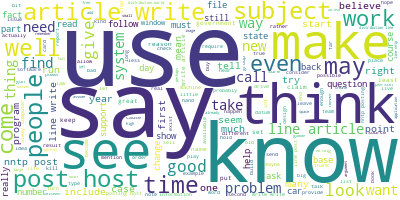

In [33]:
data = df['text'].to_list()

long_string = ','.join(data)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

**LDA пример**

In [34]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim #don't skip
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
df.head(3)

,text,target,target_names
0,thing subject car nntp post host line wonder c...,7,rec.autos
1,poll final summary final call clock report key...,4,comp.sys.mac.hardware
2,subject question computer network distribution...,4,comp.sys.mac.hardware


In [36]:
data_words = [d.split() for d in data]

In [37]:
#создадим биграмы
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [38]:
#сделаем биграмы
data_words = [bigram_mod[doc] for doc in data_words]

In [39]:
print(data_words[1])

['poll', 'final', 'summary', 'final', 'call', 'clock', 'report', 'keyword', 'acceleration', 'clock', 'upgrade', 'article', 'line', 'post_host', 'fair', 'number', 'brave', 'soul', 'upgrade', 'clock_oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'rated', 'speed', 'add', 'card', 'adapter', 'heat_sink', 'hour', 'usage', 'day', 'floppy_disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'next', 'day', 'add', 'network', 'knowledge', 'base', 'clock', 'upgrade', 'answer', 'poll', 'thank']


Приближаемся непосредственно к LDA

In [40]:
#объявим два основных параметра LDA
#словарь
id2word = corpora.Dictionary(data_words)
#и перейдем к частоте терминов в документе
corpus = [id2word.doc2bow(text) for text in data_words]

In [41]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]


Не очень понятно...
<br>
Но, вообще говоря, каждый tuple представляет собой id слова и количество раз, которое оно встретилось в $i$-м документе
<br>
Посмотрим в более читабельном виде:

In [42]:
print([[(id2word[idd], cnt) for idd, cnt in pair] for pair in corpus[:1]])

[[('addition', 1), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('could', 1), ('day', 1), ('door', 2), ('early', 1), ('engine', 1), ('enlighten', 1), ('front_bumper', 1), ('funky', 1), ('history', 1), ('host', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp_post', 1), ('production', 1), ('really', 1), ('rest', 1), ('see', 1), ('separate', 1), ('small', 1), ('spec', 1), ('sport', 1), ('subject', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('wonder', 1), ('year', 1)]]


Теперь лучше
<br>
Построим модель

In [43]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, #это нам известно, так как 20 новостных групп 
                                            random_state=SEED,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 3min 54s, sys: 22.3 s, total: 4min 16s
Wall time: 2min 41s


In [44]:
lda_model.print_topics()

[(0,
  '0.134*"team" + 0.126*"game" + 0.099*"play" + 0.041*"division" + 0.038*"score" + 0.032*"family" + 0.027*"wing" + 0.021*"baseball" + 0.021*"terrorism" + 0.015*"ice"'),
 (1,
  '0.078*"space" + 0.022*"launch" + 0.022*"earth" + 0.022*"moon" + 0.021*"orbit" + 0.019*"mission" + 0.019*"digital" + 0.019*"technical" + 0.019*"edge" + 0.016*"satellite"'),
 (2,
  '0.094*"player" + 0.065*"screen" + 0.062*"video" + 0.061*"display" + 0.053*"input" + 0.052*"monitor" + 0.050*"character" + 0.037*"internal" + 0.026*"font" + 0.023*"output"'),
 (3,
  '0.057*"line" + 0.044*"write" + 0.028*"article" + 0.024*"subject" + 0.018*"get" + 0.018*"good" + 0.014*"host" + 0.013*"look" + 0.013*"would" + 0.013*"need"'),
 (4,
  '0.205*"gun" + 0.080*"scsi" + 0.059*"weapon" + 0.053*"firearm" + 0.027*"dept" + 0.026*"motherboard" + 0.026*"crime" + 0.025*"violence" + 0.020*"gun_control" + 0.017*"shoot"'),
 (5,
  '0.054*"shall" + 0.054*"nature" + 0.046*"route" + 0.031*"event" + 0.030*"rider" + 0.030*"dog" + 0.025*"obser

**Метрики качества**

Возникает разумный вопрос: как же понять хороша ли и насколько построенная модель?

Рассмотрим, как же можно измерить качество полученной модели

**Перплексия (Perplexity)**

Перплексия — известная в вычислительной лингвистике мера качества модели языка. В данном случае моделью языка является условное распределение слов в документах

Перплексия коллекции $D$ для языковой модели $p(w|d)$:

$$P(D) = \exp(-\frac{1}{n}\sum_{d \in D}\sum_{w \in d} n_{dw}\ln p(w|d)), n = \sum_{d \in D}\sum_{w \in d} n_{dw}$$

**Замечание:**
<br>
Если подставить в качестве распределения слов в документах равномерное распределение, $p(w|d) = \frac{1}{|W|}$, то получится, что $P(D) = |W|$.

По сути это мера неопределенности/различности слов в тексте. Перплексия может быть вычислена как по отложенной выборке, так и по всей коллекции. Во втором случае есть риск переобучения, но, как показывают эксперименты, перплексии на отложенной выборке и исходной на больших объема данных практически не отличаются. В связи с этим, рекомендуется вычислять перплексию по всей коллекции, если выборка достаточна большая.

**_Чем меньше, тем лучше_**, показывает насколько хорошо построилось матричное разложение

**Недостатки**: перплексия не отвечает на вопрос "на сколько интерпретируемы темы", а лишь показывает как хорошо построилось матричное разложение.


**Когерентность (Согласованность)**

 Когерентность темы — мера, которая показывает, насколько слова, встречающиеся рядом в текстах, оказываются в топах одних и тех же тем.
 
 Когерентность коррелирует как раз с экспертными оценками интерпретируемости темы, тем самым позволяя автоматически отвечать на вопрос "на сколько тема интерпретируема"
 
 Когерентность темы $t$ — средняя поточечная взаимная информация топ-слов темы (pointwise mutual information, PMI), когерентность темы $t$ по $k$ топовым словам (обычно k $\leq$ 20):
 
$$PMI_{t} = \frac{2}{k(k-1)}\sum_{i=1}^{k-1}\sum_{k=i}^{k}PMI(w_i, w_j),$$
где $w_i$-$i$-й термин в порядке убывания $\phi_{wt}$ (вероятности термина в теме).

Поточечная взаимная информация:
$$PMI(u, v) = \ln \frac{|D|N_{uv}}{N_uN_v},$$
где 

* $N_{uv}$ - число документов, в которых термины $u$ и $v$ хотя бы один раз встречаются рядом в окне $k$,
* $N_u$ - число документов, в которых $N_u$ встретился хотя бы 1 раз. Чем выше величина поточечной взаимной информации, тем выше неслучайность того, что два слова стоят рядом.

**_Чем больше, тем лучше_**

In [45]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

coher_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
print('Coherence:', coher_lda_model.get_coherence())

Perplexity:  -13.524249104060475
Coherence: 0.4487904804656546


In [46]:
%%time
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


CPU times: user 38.3 s, sys: 1.02 s, total: 39.3 s
Wall time: 50.5 s


In [ ]:
pyLDAvis.display(vis)

Каждый пузырь на левом графике представляет тему. Чем больше пузырь, тем больше распространена эта тема. Хорошая тематическая модель будет иметь довольно большие непересекающиеся пузыри, разбросанные по всей диаграмме, а не сгруппированные в одном квадранте.

Если навести курсор на один из пузырей, справа обновятся полосы графиков. Эти слова являются ключевыми, формирующие выбранную тему.

Другой подход тематического моделирования - Additive Regularization of Topic Models (ARTM), который заключался в регуляризации PLSA с целью получения лучших моделей. Для этого предполагается ввести дополнительные критерии как регуляризаторы в модель PLSA, за счет чего модель получается более гибкой и ее можно адаптировать к большему числу задач.
<br>
Инструмент - BigARTM

$$\sum_{d \in D}\sum_{w \in d}n_{dw} \ln \sum_{t \in T} \phi_{wt} \theta_{td} + \sum_{i=1}^{k}\lambda_{i}R(\Phi, \Theta) \rightarrow \max_{\Phi \Theta}$$

$\lambda_i$ - коэффициенты регуляризации

На данный момент, в основном, регуляризаторы добавляются по одному и у каждого регуляризатора оптимизируется этот коэффициент в ходе нескольких пробных запусков модели.

| LDA | ARTM |
| --- | --- |
| Популярный, очень изучен | Тоже весьма популярен и молод|
| Множество модификаций для различных задач | Мощный аппарат регуляризаторов для изменения модели|
|Для каждой новой задачи надо искать реализацию| Одна реализация для разных задач|
|Нужно настраивать гиперпараметры|Нужно настраивать параметры регуляризации|

## Полезные источники


* [Features encoding](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)
* [Word2Vec](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
* [EM-algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)
* [BigARTM](https://github.com/bigartm/bigartm)
* [Тематическое моделирование, Воронцов, методичка](http://www.machinelearning.ru/wiki/images/2/22/Voron-2013-ptm.pdf)